In [1]:
!pip install libemg

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scipyio
import seaborn as sns
import pandas as pd
from libemg.feature_extractor import FeatureExtractor
from libemg.utils import get_windows
from google.colab import drive
import os

**Reading Dataset**

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
gestures_label = {
	 'Thumb_UP' : 0,
	 'Index' : 1,
	 'Right_Angle' : 2,
	 'Peace' : 3,
	 'Index_Little' : 4,
	 'Thumb_Little' : 5,
	 'Hand_Close' : 6,
	 'Hand_Open' : 7,
	 'Wrist_Extension' : 8,
	 'Wrist_Flexion' : 9,
	 'Ulner_Deviation' : 10,
	 'Radial_Deviation' : 11
}

gestures = ['Thumb_UP', 'Index_Little', 'Right_Angle', 'Peace', 'Index', 'Thumb_Little', 'Hand_Close', 'Hand_Open',
	 'Wrist_Extension', 'Wrist_Flexion', 'Ulner_Deviation', 'Radial_Deviation'
]

In [66]:
persons = ["Arifa", "Arnob", "Ashis", "Bayezid", "Bushra", "Choity_new", "Eftekhar",
           "Fahim", "Humaid", "Humayun", "Johir", "Joy", "Mamun", "Noman", "Piyus", "Sazzad",
           "Shafi", "Shourav", "Tamim", "Wadud"]

In [7]:
def get_gesture_label(gesture):
  return gestures_label [gesture];

In [8]:
def feature_extraction(channelvalues, gesture):
  # creating windows
  windows = get_windows(channelvalues, 150, 150)
  # extract feature
  fe = FeatureExtractor()
  feature_list = ['MAV', 'SSC', 'ZC', 'WL']
  features = fe.extract_features(feature_list, windows)
  #print("Len : "+str(len(features)))
  # creating feature matrixs
  extracted_feature_array = []
  extracted_gesture_array = []
  for i in range(33):
    features_matrix = [
        features['MAV'][i],
        features['SSC'][i],
        features['ZC'][i],
        features['WL'][i],
    ]
    extracted_feature_array.append(features_matrix)
    extracted_gesture_array.append(get_gesture_label(gesture))
  return extracted_feature_array, extracted_gesture_array

In [9]:
def get_processed_data(matfilepath, gesture):
  # read mat file
  matdata = scipyio.loadmat(matfilepath)
  # transpose the matrix
  values = np.transpose(matdata['value'])
  # remove the first 3000 values
  values = values[3000:]
  return feature_extraction(values, gesture)


In [10]:
def get_input(persons, gestures):
  input_array = []
  input_gest = []
  for person in persons:
    for gest in gestures:
      for i in range(5):
        matfilepath = "gdrive/My Drive/Forearm Invariant Data/"+person+"/Rest/"+gest+"-"+str(i+1)+".mat"
        #print(matfilepath)
        processed_matrix, gesture_array = get_processed_data(matfilepath, gest)
        gest_label = get_gesture_label(gest)
        input_array = input_array + processed_matrix
        input_gest = input_gest + gesture_array
  return input_array, input_gest

In [67]:
X, Y = get_input(persons, gestures)

In [68]:
len(X), len(Y)

(39600, 39600)

In [69]:
#
df = pd.DataFrame(X[0])
index = pd.Index(['MAV', 'SSC', 'ZC', 'WL'])
df = df.set_index(index)
df

,0,1,2,3,4,5,6,7
MAV,0.017122,0.013281,0.036914,0.017578,0.035775,0.021419,0.029264,0.017969
SSC,103.000000,105.000000,100.000000,87.000000,87.000000,91.000000,82.000000,109.000000
ZC,16.000000,31.000000,39.000000,32.000000,34.000000,35.000000,34.000000,51.000000
WL,2.133789,1.962891,6.782227,2.587891,4.282227,2.631836,3.710938,2.910156


In [70]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((39600, 4, 8), (39600,))

**Model Building**

In [71]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X,Y,
    test_size = .2, shuffle=True, random_state=0
)

In [72]:
len(x_train), len(y_train)

(31680, 31680)

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the input shape
input_shape = (4, 8)

# Create a Sequential model
model = Sequential()

# Add a Conv1D layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

# Add a MaxPooling1D layer (optional)
model.add(MaxPooling1D(pool_size=2))

# Flatten the output before feeding it to a Dense layer
model.add(Flatten())

# Add a Dense layer
model.add(Dense(64, activation='relu'))

# Output layer for classification (adjust units according to the number of classes)
# Assuming classes are integers starting from 0
model.add(Dense(12, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 2, 32)             800       
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 1, 32)             0         
 ng1D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 64)                2112      
                                                                 
 dense_21 (Dense)            (None, 12)                780       
                                                                 
Total params: 3692 (14.42 KB)
Trainable params: 3692 (14.42 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [74]:
# Fit the model with training data
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/30
990/990 [==============================] - 2s 2ms/step - loss: 2.0734 - accuracy: 0.3675 - val_loss: 1.4227 - val_accuracy: 0.4801
Epoch 2/30
990/990 [==============================] - 1s 1ms/step - loss: 1.3259 - accuracy: 0.5253 - val_loss: 1.2540 - val_accuracy: 0.5357
Epoch 3/30
990/990 [==============================] - 2s 2ms/step - loss: 1.1720 - accuracy: 0.5733 - val_loss: 1.1124 - val_accuracy: 0.6016
Epoch 4/30
990/990 [==============================] - 1s 1ms/step - loss: 1.0800 - accuracy: 0.6051 - val_loss: 1.0490 - val_accuracy: 0.6112
Epoch 5/30
990/990 [==============================] - 2s 2ms/step - loss: 1.0133 - accuracy: 0.6289 - val_loss: 0.9613 - val_accuracy: 0.6475
Epoch 6/30
990/990 [==============================] - 2s 2ms/step - loss: 0.9508 - accuracy: 0.6512 - val_loss: 0.9546 - val_accuracy: 0.6514
Epoch 7/30
990/990 [==============================] - 2s 2ms/step - loss: 0.8916 - accuracy: 0.6714 - val_loss: 0.9784 - val_accuracy: 0.6439
Epoch 

**Classification Report**

In [75]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report : ")
print(classification_report(y_test, y_pred_classes))

248/248 [==============================] - 0s 935us/step
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      0.65      0.72       646
           1       0.77      0.67      0.72       648
           2       0.66      0.82      0.73       675
           3       0.72      0.90      0.80       674
           4       0.80      0.84      0.82       676
           5       0.75      0.91      0.82       652
           6       0.90      0.77      0.83       693
           7       0.94      0.75      0.83       634
           8       0.92      0.94      0.93       687
           9       0.99      0.87      0.93       633
          10       0.94      0.97      0.95       674
          11       0.97      0.92      0.95       628

    accuracy                           0.83      7920
   macro avg       0.85      0.83      0.84      7920
weighted avg       0.85      0.83      0.84      7920



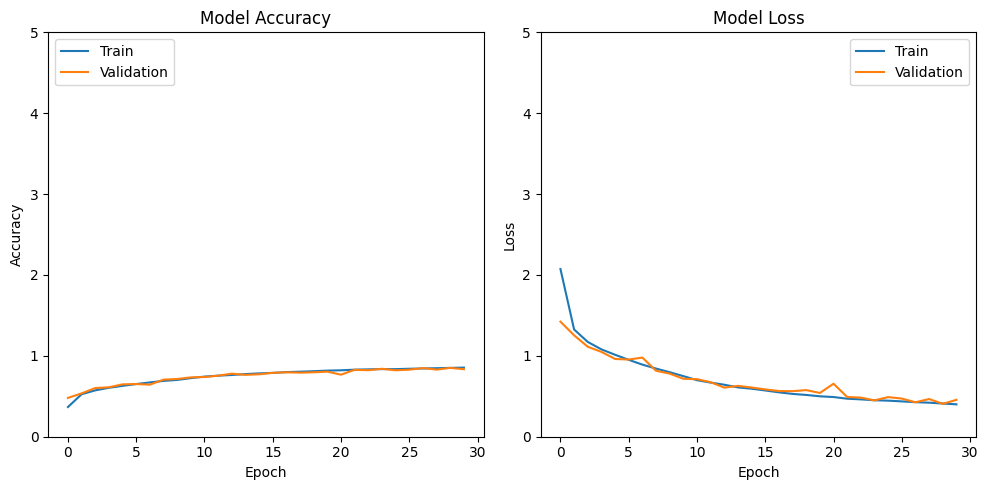

In [76]:
# Plotting model accuracy and loss
def plot_history(history):
    plt.figure(figsize=(10, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.ylim(0, 5)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.ylim(0, 5)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot the history
plot_history(history)